In [1]:
##The dataset is loaded to your GDrive so need to be mounted
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/Satellite Project/')

Mounted at /content/drive


In [2]:
START_IDX = 0
saved_model_name = 'DiffUNet.pt'

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import StepLR

import os
import gc
from tqdm import tqdm

from utils import *
from models.diff_unet import DiffUNet
from datasets.dataset import ChangeDetectionDataset

## Read Data


In [4]:
training_path = './trainval/'

In [5]:
after_images = read_data(training_path, 'after',START_IDX)
before_images = read_data(training_path,'before',START_IDX)
labels = read_data(training_path,'label',START_IDX)

Time taken to read  after  images: 217.79 seconds
Time taken to read  before  images: 223.02 seconds
Time taken to read  label  images: 208.03 seconds


In [6]:
# diff_images = read_data(training_path,'diff',START_IDX)
# labels = read_data(training_path,'label',START_IDX)

In [7]:
print(len(before_images))
print(len(after_images))
print(len(labels))

4868
4868
4868


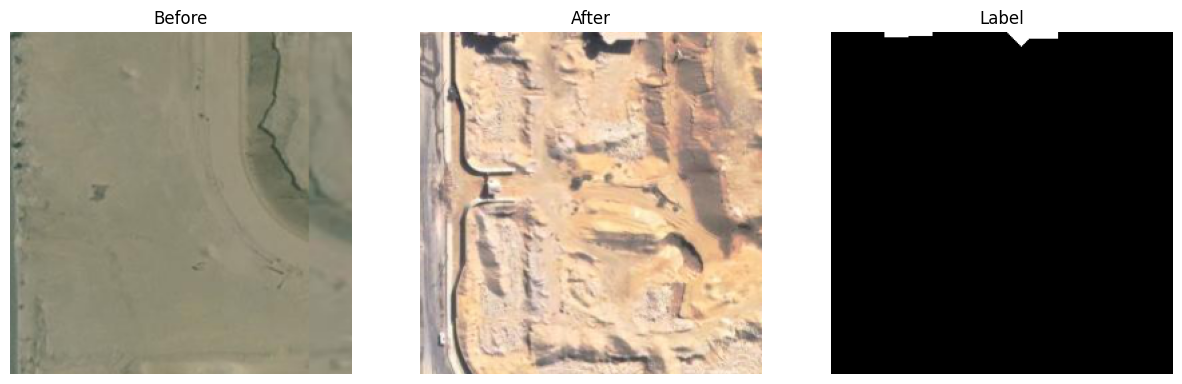

In [8]:
index = 0
display_images([before_images[index], after_images[index]], labels[index])

## Create Datasets


In [9]:
batch_size = 16
train_val_ratio = 0.8

In [10]:
# Define transformations
transform_rgb = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform_label = transforms.Compose([
    transforms.ToTensor(),
])

# Assuming you have instantiated your dataset like this
dataset = ChangeDetectionDataset(before_images, after_images, labels, transform_rgb, transform_label)

# Define the indices for train and validation sets
train_size = int(train_val_ratio * len(dataset))
val_size = len(dataset) - train_size

torch.manual_seed(42)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Define data loaders for train and validation sets
train_loader = DataLoader(dataset = train_dataset, batch_size=batch_size, shuffle = True)
val_loader = DataLoader(dataset = val_dataset, batch_size=batch_size, shuffle = True)

In [11]:
print("Percentage of pure black masks in training set:", count_pure_black_masks(train_loader))
print("Percentage of pure black masks in validation set:", count_pure_black_masks(val_loader))

Percentage of pure black masks in training set: 66.84643040575244
Percentage of pure black masks in validation set: 64.57905544147845


In [12]:
print("Train size:", len(train_loader) * batch_size)
print("Validation size:", len(val_loader) * batch_size)

Train size: 3904
Validation size: 976


In [13]:
before_images, after_images, label = train_dataset[0]
print(before_images.shape)
print(after_images.shape)
print(label.shape)

torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])


In [14]:
# Create an instance of the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DiffUNet(n_channels = 3, n_classes = 1).to(device)
criterion = nn.BCEWithLogitsLoss()
print(device)

cuda


In [15]:
learning_rate = 0.001
threshold = 0.3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=10, gamma=0.2)

In [ ]:
# from torchsummary import summary
# summary(model,input_size=[(3,256,256),(3,256,256)])

## Train Model


In [17]:
def train_model(model, device, train_loader, criterion, optimizer, scheduler, num_epochs=50, save_dir="saved_models"):
    n_steps = len(train_loader)
    jaccard_loss = 0.0
    best_jaccard_score = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        total_iou = 0.0

        predicted_masks_list = []
        true_masks_list = []
        for data in tqdm(train_loader):
            before_image, after_image, true_masks = data
            before_image = before_image.to(device)
            after_image = after_image.to(device)
            true_masks = true_masks.to(device)

            optimizer.zero_grad()
            masks_pred = model(before_image, after_image)  # Pass both before and after images to the model
            loss = criterion(masks_pred, true_masks)
            loss += 0.6 * jaccard_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            pred_masks = (masks_pred > threshold).float()

            for i, pred_mask in enumerate(pred_masks):
                pred_mask = pred_mask.squeeze().cpu().numpy()
                predicted_masks_list.append(pred_mask)

                true_mask = true_masks[i].squeeze().cpu().numpy()
                true_masks_list.append(true_mask)

            # Clearing unnecessary variables from GPU memory
            del before_image, true_masks, masks_pred, loss

        epoch_iou, overall_accuracy = evaluate(predicted_masks_list, true_masks_list)
        epoch_loss = running_loss / n_steps
        jaccard_loss = 1 - epoch_iou

        print(f'Epoch [{epoch + 1}/{num_epochs}] Finished, Loss: {epoch_loss:.5f}, Jaccard Index: {epoch_iou*100:.3f}%, Accuracy: {overall_accuracy*100:.3f}%, Learning Rate: {optimizer.param_groups[0]["lr"]}')
        # Step the scheduler based on the validation IoU
        scheduler.step()

        model_path = os.path.join(save_dir, saved_model_name)
        if epoch_iou > best_jaccard_score:
            best_jaccard_score = epoch_iou
            print(f'Best Jaccard Index: {best_jaccard_score*100:.5f}%')
            torch.save(model.state_dict(), model_path)

        running_loss = 0.0

In [18]:
# Train the model
train_model(model, device, train_loader, criterion, optimizer, scheduler, num_epochs=35, save_dir= "saved_models")

100%|██████████| 244/244 [04:15<00:00,  1.05s/it]


Epoch [1/35] Finished, Loss: 0.11037, Jaccard Index: 0.71125, Accuracy: 0.95433, Learning Rate: 0.001
Best Jaccard Index: 0.71125


100%|██████████| 244/244 [04:17<00:00,  1.06s/it]


Epoch [2/35] Finished, Loss: 0.16501, Jaccard Index: 0.70742, Accuracy: 0.95511, Learning Rate: 0.001


100%|██████████| 244/244 [04:17<00:00,  1.05s/it]


Epoch [3/35] Finished, Loss: 0.16438, Jaccard Index: 0.71726, Accuracy: 0.95592, Learning Rate: 0.001
Best Jaccard Index: 0.71726


100%|██████████| 244/244 [04:17<00:00,  1.05s/it]


Epoch [4/35] Finished, Loss: 0.15777, Jaccard Index: 0.73309, Accuracy: 0.95783, Learning Rate: 0.001
Best Jaccard Index: 0.73309


100%|██████████| 244/244 [04:17<00:00,  1.05s/it]


Epoch [5/35] Finished, Loss: 0.15404, Jaccard Index: 0.72709, Accuracy: 0.95779, Learning Rate: 0.001


100%|██████████| 244/244 [04:17<00:00,  1.05s/it]


Epoch [6/35] Finished, Loss: 0.15115, Jaccard Index: 0.74149, Accuracy: 0.96018, Learning Rate: 0.001
Best Jaccard Index: 0.74149


100%|██████████| 244/244 [04:17<00:00,  1.05s/it]


Epoch [7/35] Finished, Loss: 0.14877, Jaccard Index: 0.73729, Accuracy: 0.95969, Learning Rate: 0.001


100%|██████████| 244/244 [04:17<00:00,  1.05s/it]


Epoch [8/35] Finished, Loss: 0.15048, Jaccard Index: 0.74086, Accuracy: 0.96003, Learning Rate: 0.001


100%|██████████| 244/244 [04:17<00:00,  1.05s/it]


Epoch [9/35] Finished, Loss: 0.15237, Jaccard Index: 0.73014, Accuracy: 0.95862, Learning Rate: 0.001


100%|██████████| 244/244 [04:17<00:00,  1.05s/it]


Epoch [10/35] Finished, Loss: 0.14418, Jaccard Index: 0.76124, Accuracy: 0.96243, Learning Rate: 0.001
Best Jaccard Index: 0.76124


100%|██████████| 244/244 [04:17<00:00,  1.05s/it]


Epoch [11/35] Finished, Loss: 0.13228, Jaccard Index: 0.76747, Accuracy: 0.96463, Learning Rate: 0.0002
Best Jaccard Index: 0.76747


100%|██████████| 244/244 [04:17<00:00,  1.05s/it]


Epoch [12/35] Finished, Loss: 0.12872, Jaccard Index: 0.77706, Accuracy: 0.96569, Learning Rate: 0.0002
Best Jaccard Index: 0.77706


100%|██████████| 244/244 [04:17<00:00,  1.05s/it]


Epoch [13/35] Finished, Loss: 0.12408, Jaccard Index: 0.77872, Accuracy: 0.96649, Learning Rate: 0.0002
Best Jaccard Index: 0.77872


100%|██████████| 244/244 [04:17<00:00,  1.05s/it]


Epoch [14/35] Finished, Loss: 0.12364, Jaccard Index: 0.78525, Accuracy: 0.96665, Learning Rate: 0.0002
Best Jaccard Index: 0.78525


100%|██████████| 244/244 [04:17<00:00,  1.05s/it]


Epoch [15/35] Finished, Loss: 0.12304, Jaccard Index: 0.78331, Accuracy: 0.96634, Learning Rate: 0.0002


100%|██████████| 244/244 [04:17<00:00,  1.06s/it]


Epoch [16/35] Finished, Loss: 0.12177, Jaccard Index: 0.78913, Accuracy: 0.96716, Learning Rate: 0.0002
Best Jaccard Index: 0.78913


100%|██████████| 244/244 [04:17<00:00,  1.05s/it]


Epoch [17/35] Finished, Loss: 0.11988, Jaccard Index: 0.78679, Accuracy: 0.96751, Learning Rate: 0.0002


100%|██████████| 244/244 [04:16<00:00,  1.05s/it]


Epoch [18/35] Finished, Loss: 0.11862, Jaccard Index: 0.78742, Accuracy: 0.96779, Learning Rate: 0.0002


100%|██████████| 244/244 [04:17<00:00,  1.05s/it]


Epoch [19/35] Finished, Loss: 0.11818, Jaccard Index: 0.78959, Accuracy: 0.96832, Learning Rate: 0.0002
Best Jaccard Index: 0.78959


100%|██████████| 244/244 [04:17<00:00,  1.05s/it]


Epoch [20/35] Finished, Loss: 0.11606, Jaccard Index: 0.80295, Accuracy: 0.96906, Learning Rate: 0.0002
Best Jaccard Index: 0.80295


100%|██████████| 244/244 [04:17<00:00,  1.05s/it]


Epoch [21/35] Finished, Loss: 0.11129, Jaccard Index: 0.80021, Accuracy: 0.96926, Learning Rate: 4e-05


100%|██████████| 244/244 [04:17<00:00,  1.05s/it]


Epoch [22/35] Finished, Loss: 0.11282, Jaccard Index: 0.79770, Accuracy: 0.96944, Learning Rate: 4e-05


100%|██████████| 244/244 [04:17<00:00,  1.05s/it]


Epoch [23/35] Finished, Loss: 0.11175, Jaccard Index: 0.80061, Accuracy: 0.96998, Learning Rate: 4e-05


100%|██████████| 244/244 [04:17<00:00,  1.05s/it]


Epoch [24/35] Finished, Loss: 0.11056, Jaccard Index: 0.80414, Accuracy: 0.97022, Learning Rate: 4e-05
Best Jaccard Index: 0.80414


100%|██████████| 244/244 [04:17<00:00,  1.05s/it]


Epoch [25/35] Finished, Loss: 0.10993, Jaccard Index: 0.80195, Accuracy: 0.97029, Learning Rate: 4e-05


100%|██████████| 244/244 [04:17<00:00,  1.06s/it]


Epoch [26/35] Finished, Loss: 0.11029, Jaccard Index: 0.80622, Accuracy: 0.96993, Learning Rate: 4e-05
Best Jaccard Index: 0.80622


100%|██████████| 244/244 [04:17<00:00,  1.06s/it]


Epoch [27/35] Finished, Loss: 0.10870, Jaccard Index: 0.80331, Accuracy: 0.97065, Learning Rate: 4e-05


100%|██████████| 244/244 [04:17<00:00,  1.06s/it]


Epoch [28/35] Finished, Loss: 0.10929, Jaccard Index: 0.80349, Accuracy: 0.97050, Learning Rate: 4e-05


100%|██████████| 244/244 [04:17<00:00,  1.05s/it]


Epoch [29/35] Finished, Loss: 0.10996, Jaccard Index: 0.79843, Accuracy: 0.97024, Learning Rate: 4e-05


100%|██████████| 244/244 [04:17<00:00,  1.05s/it]


Epoch [30/35] Finished, Loss: 0.10972, Jaccard Index: 0.80250, Accuracy: 0.97081, Learning Rate: 4e-05


100%|██████████| 244/244 [04:17<00:00,  1.05s/it]


Epoch [31/35] Finished, Loss: 0.10880, Jaccard Index: 0.80342, Accuracy: 0.97100, Learning Rate: 8.000000000000001e-06


100%|██████████| 244/244 [04:17<00:00,  1.06s/it]


Epoch [32/35] Finished, Loss: 0.10864, Jaccard Index: 0.80172, Accuracy: 0.97077, Learning Rate: 8.000000000000001e-06


100%|██████████| 244/244 [04:17<00:00,  1.05s/it]


Epoch [33/35] Finished, Loss: 0.10872, Jaccard Index: 0.81106, Accuracy: 0.97085, Learning Rate: 8.000000000000001e-06
Best Jaccard Index: 0.81106


100%|██████████| 244/244 [04:17<00:00,  1.06s/it]


Epoch [34/35] Finished, Loss: 0.10713, Jaccard Index: 0.80132, Accuracy: 0.97091, Learning Rate: 8.000000000000001e-06


100%|██████████| 244/244 [04:17<00:00,  1.06s/it]


Epoch [35/35] Finished, Loss: 0.10907, Jaccard Index: 0.80113, Accuracy: 0.97067, Learning Rate: 8.000000000000001e-06


In [19]:
torch.cuda.empty_cache()

In [16]:
# # Load the latest saved model
model = load_model(model, save_dir="saved_models", model_name="DiffUNet.pt")

## Validate Model


In [20]:
before_images_list, after_images_list, predicted_masks_list, true_masks_list = validate(model, val_loader, device, threshold)

In [21]:
jaccard, overall_accuracy = evaluate(predicted_masks_list, true_masks_list)
print("Mean Jaccard Index :", jaccard)
print("Overall Accuracy :", overall_accuracy)

Mean Jaccard Index : 0.7964747292551888
Overall Accuracy : 0.9683155161644155


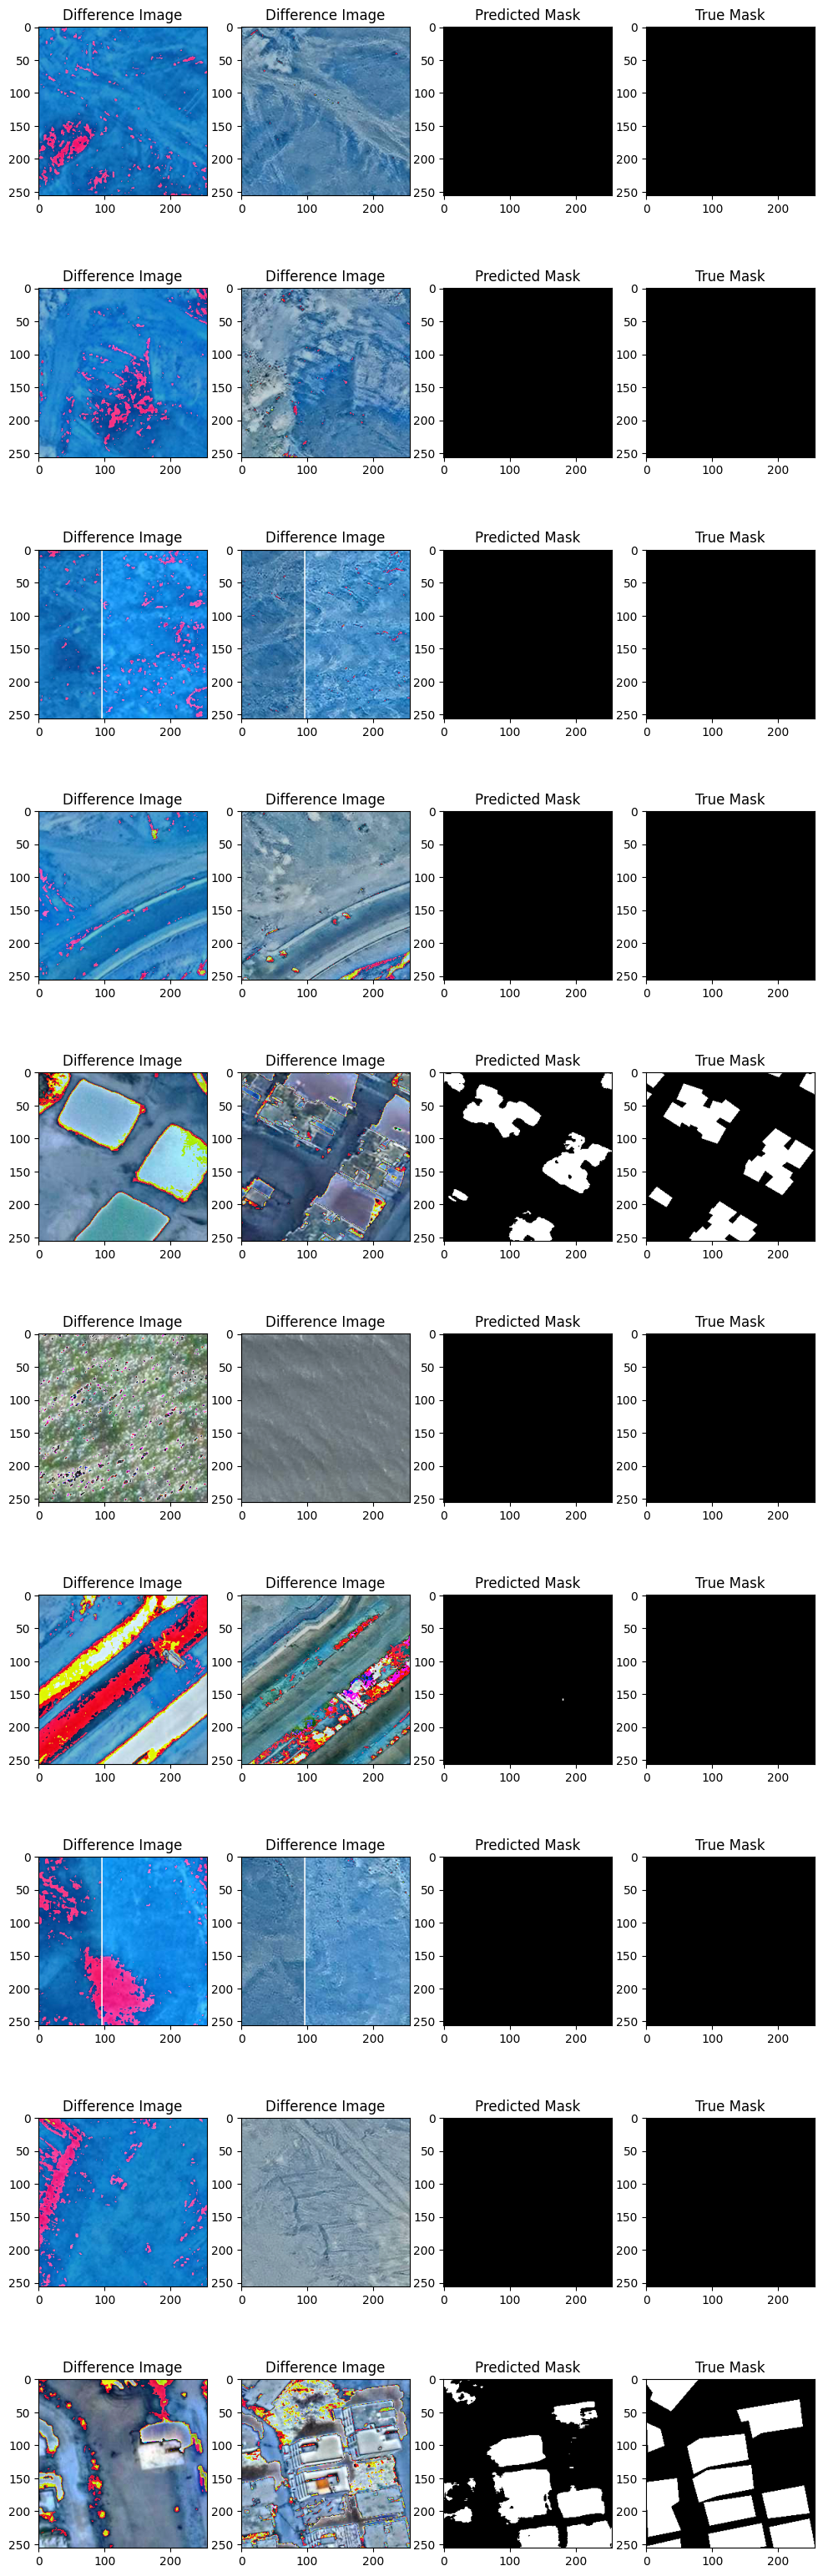

In [22]:
display_predicted_images(before_images_list, after_images_list, predicted_masks_list, true_masks_list)

In [23]:
# save_predictions(predicted_masks_list, predicted_images_dir)

NameError: name 'predicted_images_dir' is not defined